In [117]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from scipy.io import wavfile
from scipy.fft import fft, fftfreq, fftshift
import scipy.io
from scipy import signal

import IPython

import os

PATH_IMG = "./imgs/"

print(os.getcwd())
print(os.listdir())

def cm_to_inch(value):
    return value/2.54

/home/andre/Documents/Git/STD_DCA0107/U1
['filtragem.ipynb', 'Projeto_Filtragem_remez.pdf', 'audio_ruidoso.wav', 'imgs', 'parametros.jpg', 'exemplo.wav', 'audio_filtrado.wav']


In [118]:
audio = os.listdir()[2]

IPython.display.Audio(audio)

# Espectograma e FFT do áudio

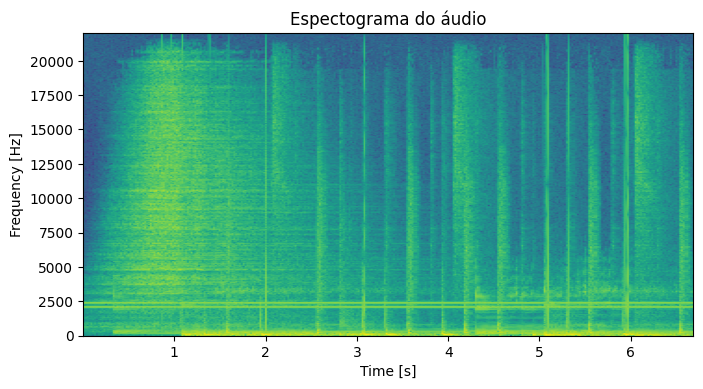

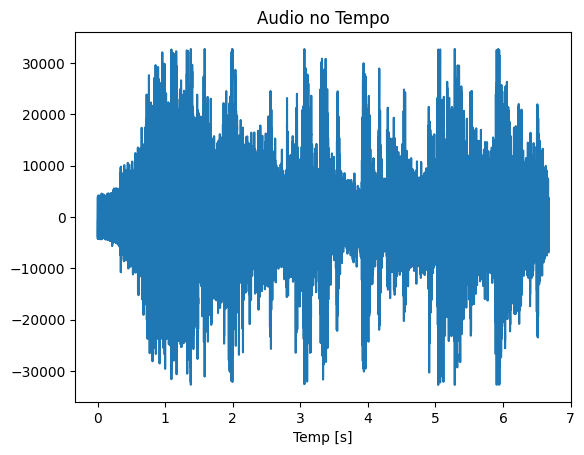

In [130]:
fs, data = scipy.io.wavfile.read(audio)

figure(figsize=(cm_to_inch(20), cm_to_inch(10)), dpi=100)

spec, freqs, t, _ = plt.specgram(data, NFFT=1024, Fs=fs)

plt.title("Espectograma do áudio")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')

plt.savefig(PATH_IMG+"Espectograma_audio.png")

plt.show()

plt.plot(np.linspace(0, t[len(t)-1], len(data)),data)
plt.title("Audio no Tempo")
plt.xlabel("Temp [s]")

plt.savefig(PATH_IMG+"audio_no_tempo.png")

plt.show()

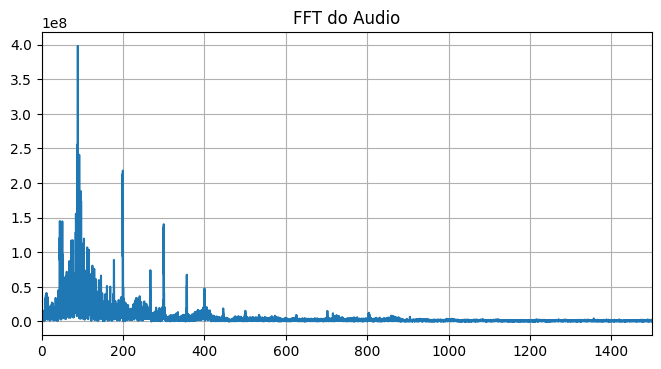

In [120]:
data_fft = fft(data)

Nfft = len(data_fft)

freqs = np.linspace(0, fs/2, int(Nfft/2+1))

figure(figsize=(cm_to_inch(20), cm_to_inch(10)), dpi=100)

plt.title('FFT do Audio')
plt.plot(freqs, abs(data_fft[0:len(freqs)]))
plt.grid()

plt.xlim(0, 1500)

plt.show()

# Adição do Ruído

$n(t) = \cos{(2\pi f_1 t)} + \cos{(2\pi f_2 t)}$

![Parametros](./parametros.jpg)

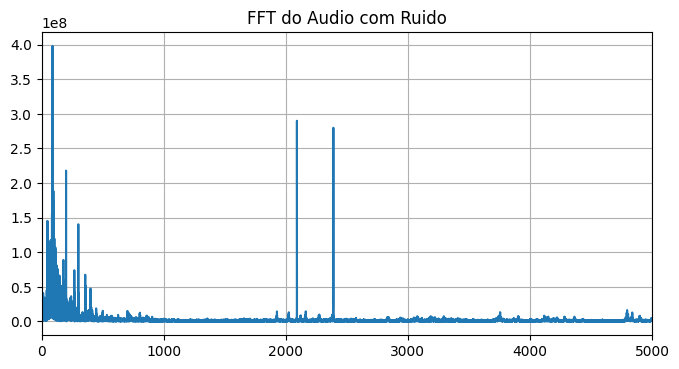

In [121]:
f1 = 2.1e3
f2 = 2.4e3

Amplitude = 1e3

time = np.linspace(0, t[len(t)-1], len(data))
n_t = Amplitude*np.cos(2 * np.pi * f1 * time) + Amplitude*np.cos(2 * np.pi * f2 * time)

data_ruido = data + n_t

data_ruido_fft = fft(data_ruido)

Nfft = len(data_ruido_fft)

freqs = np.linspace(0, fs/2, int(Nfft/2+1))

figure(figsize=(cm_to_inch(20), cm_to_inch(10)), dpi=100)

plt.title('FFT do Audio com Ruido')
plt.plot(freqs, abs(data_ruido_fft[0:len(freqs)]))
plt.grid()

plt.xlim(0, 5000)

plt.show()

scipy.io.wavfile.write('audio_ruidoso.wav', fs, data_ruido.astype(np.int16))
IPython.display.Audio("audio_ruidoso.wav")

# Realizando a Filtragem

In [122]:
def plot_response(w, h, title):
    "Utility function to plot response functions"
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(w, 20*np.log10(np.abs(h)))
    ax.set_ylim(-40, 5)
    ax.grid(True)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Gain (dB)')
    ax.set_title(title)

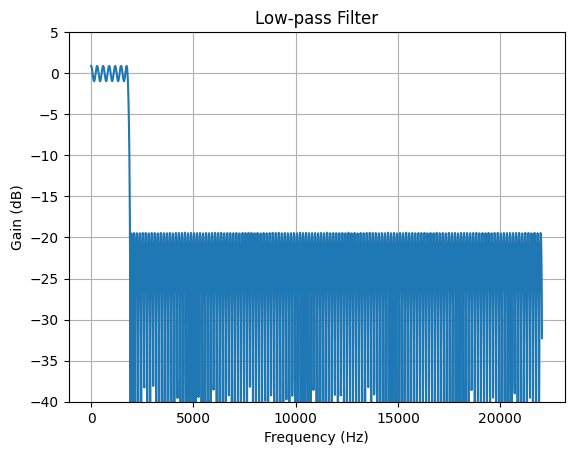

In [125]:
num_taps = 300
freq_cutoff = 1800
transition_cutoff = 100

taps = signal.remez(num_taps, [0, freq_cutoff, freq_cutoff + transition_cutoff, 0.5*fs],[1, 0], fs=fs)

w, h = signal.freqz(taps, [1], worN=2000, fs=fs)

plot_response(w, h, "Low-pass Filter")

plt.show()

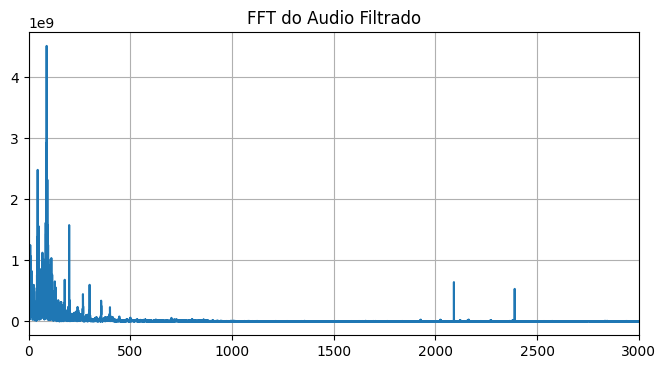

In [126]:
data_filtrado = signal.lfilter(h, 1, data_ruido)

data_filtrado_fft = fft(data_filtrado)

Nfft = len(data_filtrado_fft)

freqs = np.linspace(0, fs/2, int(Nfft/2+1))

figure(figsize=(cm_to_inch(20), cm_to_inch(10)), dpi=100)

plt.title('FFT do Audio Filtrado')
plt.plot(freqs, abs(data_filtrado_fft[0:len(freqs)]))
plt.grid()

plt.xlim(0, 3000)
# plt.ylim(0, 1e7)

plt.show()

scipy.io.wavfile.write('audio_filtrado.wav', fs, data_ruido.astype(np.int16))
IPython.display.Audio("audio_filtrado.wav")

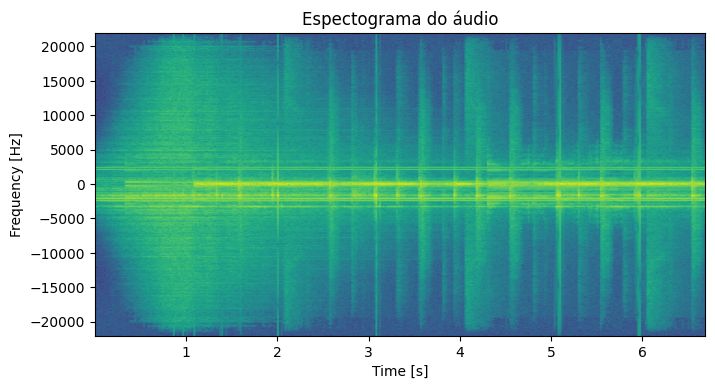

In [128]:
figure(figsize=(cm_to_inch(20), cm_to_inch(10)), dpi=100)

spec, freqs, t, _ = plt.specgram(data_filtrado, NFFT=1024, Fs=fs)

plt.title("Espectograma do áudio")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')

plt.show()